## Imports 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




## Directory Setup

In [2]:
DATA_ROOT = r'E:\eatfresh_final\eatfresh\THEDATASET'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train', 'images')
VALID_DIR = os.path.join(DATA_ROOT, 'val', 'images')
TEST_DIR = os.path.join(DATA_ROOT, 'test', 'images')

TRAIN_CSV = os.path.join(DATA_ROOT, 'fruit_train.csv')
VALID_CSV = os.path.join(DATA_ROOT, 'fruit_val.csv')
TEST_CSV = os.path.join(DATA_ROOT, 'fruit_test.csv')

print(f"Checking data directories:")
print(f"Training data exists: {os.path.exists(TRAIN_DIR)}")
print(f"Validation data exists: {os.path.exists(VALID_DIR)}")
print(f"Test data exists: {os.path.exists(TEST_DIR)}")


Checking data directories:
Training data exists: True
Validation data exists: True
Test data exists: True


### Check if using gpu

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Dataset Label Extraction

In [ ]:
def analyze_data_structure_with_csv(data_dir, csv_path):

    df = pd.read_csv(csv_path, skiprows=1)
    freshness_classes = ['fresh', 'slightly rotten', 'rotten']
    produce_classes = ['apple', 'banana', 'potato', 'carrot']
    
    files = []
    freshness_labels = []
    produce_labels = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            file_path = os.path.join(data_dir, filename)
            
            match = df[df['filename'].str.lower() == filename.lower()]
            if not match.empty:
                fruit = match.iloc[0]['fruit'].lower()
                score = match.iloc[0]['score']
                
                if fruit in produce_classes:
                    produce_label = produce_classes.index(fruit)
                else:
                    continue
                
                if score <= 0.4:
                    freshness_label = 0 
                elif score <= 0.7:
                    freshness_label = 1
                else:
                    freshness_label = 2
                
                files.append(file_path)
                produce_labels.append(produce_label)
                freshness_labels.append(freshness_label)
            else:
                continue 
                
    return files, freshness_labels, produce_labels


train_files, train_freshness_labels, train_produce_labels = analyze_data_structure_with_csv(TRAIN_DIR, TRAIN_CSV)
valid_files, valid_freshness_labels, valid_produce_labels = analyze_data_structure_with_csv(VALID_DIR, VALID_CSV)
test_files, test_freshness_labels, test_produce_labels = analyze_data_structure_with_csv(TEST_DIR, TEST_CSV)

print(f"Found training images: {len(train_files)}")
print(f"Found validation images: {len(valid_files)}")
print(f"Found test images: {len(test_files)}")

freshness_classes = ['fresh', 'slightly rotten', 'rotten']
produce_classes = ['apple', 'banana', 'potato', 'carrot']
print("\nSample training files:")
for i in range(min(5, len(train_files))):
    print(f"{train_files[i]} - Freshness: {freshness_classes[train_freshness_labels[i]]}, Produce: {produce_classes[train_produce_labels[i]]}")


Found training images: 3194
Found validation images: 909
Found test images: 469

Sample training files:
E:\eatfresh_final\eatfresh\THEDATASET\train\images\freshApple-1-_png.rf.5cb21de80e506b4e3ba2a5af9c7bd176.jpg - Freshness: fresh, Produce: apple
E:\eatfresh_final\eatfresh\THEDATASET\train\images\freshApple-109-_jpg.rf.d393aa12407cd99e05b39141ca0a884e.jpg - Freshness: fresh, Produce: apple
E:\eatfresh_final\eatfresh\THEDATASET\train\images\freshApple-112-_jpg.rf.7d08081d6cc6276dd4b8977920f09bfb.jpg - Freshness: fresh, Produce: apple
E:\eatfresh_final\eatfresh\THEDATASET\train\images\freshApple-131-_jpg.rf.cb87d2060a3ab67a577bc106e54c6168.jpg - Freshness: fresh, Produce: apple
E:\eatfresh_final\eatfresh\THEDATASET\train\images\freshApple-134-_jpg.rf.fe96358cfc96f6dea88b9f56b816a8a0.jpg - Freshness: fresh, Produce: apple


In [5]:
print("Train freshness distribution:", pd.Series(train_freshness_labels).value_counts())
print("Train produce distribution:", pd.Series(train_produce_labels).value_counts())
print("Valid freshness distribution:", pd.Series(valid_freshness_labels).value_counts())
print("Valid produce distribution:", pd.Series(valid_produce_labels).value_counts())
print("Test freshness distribution:", pd.Series(test_freshness_labels).value_counts())
print("Test produce distribution:", pd.Series(test_produce_labels).value_counts())

Train freshness distribution: 0    1853
2    1001
1     340
dtype: int64
Train produce distribution: 1    836
0    829
2    818
3    711
dtype: int64
Valid freshness distribution: 0    485
2    354
1     70
dtype: int64
Valid produce distribution: 1    238
0    236
2    232
3    203
dtype: int64
Test freshness distribution: 0    252
2    141
1     76
dtype: int64
Test produce distribution: 0    122
1    122
2    122
3    103
dtype: int64


## Dataset Label Extraction

In [6]:
class FoodFreshnessDataset(Dataset):
    def __init__(self, file_paths, freshness_labels, produce_labels, transform=None):
        self.file_paths = file_paths
        self.freshness_labels = freshness_labels
        self.produce_labels = produce_labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            freshness_label = self.freshness_labels[idx]
            produce_label = self.produce_labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, freshness_label, produce_label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            placeholder = torch.zeros((3, 224, 224))
            return placeholder, freshness_label, produce_label

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


## DataLoader

In [7]:
train_dataset = FoodFreshnessDataset(train_files, train_freshness_labels, train_produce_labels, transform=data_transforms['train'])
valid_dataset = FoodFreshnessDataset(valid_files, valid_freshness_labels, valid_produce_labels, transform=data_transforms['valid'])
test_dataset = FoodFreshnessDataset(test_files, test_freshness_labels, test_produce_labels, transform=data_transforms['test'])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)



## Model Architecture

In [ ]:
def create_multi_task_model(num_freshness_classes=3, num_produce_classes=4):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    shared_fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    freshness_head = nn.Linear(256, num_freshness_classes)
    produce_head = nn.Linear(256, num_produce_classes)

    class MultiTaskResNet(nn.Module):
        def __init__(self, base_model, shared_fc, freshness_head, produce_head):
            super(MultiTaskResNet, self).__init__()
            self.base_model = nn.Sequential(*list(base_model.children())[:-1])
            self.shared_fc = shared_fc
            self.freshness_head = freshness_head
            self.produce_head = produce_head

        def forward(self, x):
            x = self.base_model(x)
            x = x.view(x.size(0), -1)
            x = self.shared_fc(x)
            freshness_output = self.freshness_head(x)
            produce_output = self.produce_head(x)
            return freshness_output, produce_output

    return MultiTaskResNet(model, shared_fc, freshness_head, produce_head).to(device)

model = create_multi_task_model()


c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model Training

In [9]:
criterion_freshness = nn.CrossEntropyLoss()
criterion_produce = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, train_loader, valid_loader, num_epochs=10, model_path='food_multi_task_model.pth'):
    best_val_acc = 0.0
    history = {'train_freshness_acc': [], 'train_produce_acc': [], 'val_freshness_acc': [], 'val_produce_acc': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = valid_loader

            running_loss = 0.0
            freshness_corrects = 0
            produce_corrects = 0
            total_samples = 0

            for inputs, freshness_labels, produce_labels in dataloader:
                inputs, freshness_labels, produce_labels = inputs.to(device), freshness_labels.to(device), produce_labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    freshness_outputs, produce_outputs = model(inputs)
                    freshness_loss = criterion_freshness(freshness_outputs, freshness_labels)
                    produce_loss = criterion_produce(produce_outputs, produce_labels)
                    loss = freshness_loss + produce_loss

                    _, freshness_preds = torch.max(freshness_outputs, 1)
                    _, produce_preds = torch.max(produce_outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                freshness_corrects += torch.sum(freshness_preds == freshness_labels)
                produce_corrects += torch.sum(produce_preds == produce_labels)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            freshness_acc = freshness_corrects.double() / total_samples
            produce_acc = produce_corrects.double() / total_samples

            print(f'{phase} Loss: {epoch_loss:.4f} Freshness Acc: {freshness_acc:.4f} Produce Acc: {produce_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_freshness_acc'].append(freshness_acc.item())
                history['train_produce_acc'].append(produce_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_freshness_acc'].append(freshness_acc.item())
                history['val_produce_acc'].append(produce_acc.item())

                if freshness_acc + produce_acc > best_val_acc:
                    best_val_acc = freshness_acc + produce_acc
                    torch.save(model.state_dict(), model_path)
                    print(f"Model saved to {model_path}")

        print()

    return history

history = train_model(model, train_loader, valid_loader, num_epochs=10)


Epoch 1/10
train Loss: 1.8130 Freshness Acc: 0.6481 Produce Acc: 0.7148
valid Loss: 1.3102 Freshness Acc: 0.7580 Produce Acc: 0.9054
Model saved to food_multi_task_model.pth

Epoch 2/10
train Loss: 1.1500 Freshness Acc: 0.7664 Produce Acc: 0.9058
valid Loss: 0.9147 Freshness Acc: 0.8273 Produce Acc: 0.9428
Model saved to food_multi_task_model.pth

Epoch 3/10
train Loss: 0.8990 Freshness Acc: 0.7918 Produce Acc: 0.9280
valid Loss: 0.7582 Freshness Acc: 0.8438 Produce Acc: 0.9494
Model saved to food_multi_task_model.pth

Epoch 4/10
train Loss: 0.7824 Freshness Acc: 0.8068 Produce Acc: 0.9421
valid Loss: 0.6900 Freshness Acc: 0.8317 Produce Acc: 0.9538

Epoch 5/10
train Loss: 0.7099 Freshness Acc: 0.8140 Produce Acc: 0.9465
valid Loss: 0.6374 Freshness Acc: 0.8438 Produce Acc: 0.9648
Model saved to food_multi_task_model.pth

Epoch 6/10
train Loss: 0.6672 Freshness Acc: 0.8200 Produce Acc: 0.9524
valid Loss: 0.5887 Freshness Acc: 0.8526 Produce Acc: 0.9615
Model saved to food_multi_task_mo

## Test Evaluation

In [10]:
from sklearn.metrics import accuracy_score

def evaluate_model_on_test(model, test_loader):
    model.eval()
    all_freshness_preds = []
    all_produce_preds = []
    all_freshness_labels = []
    all_produce_labels = []
    
    with torch.no_grad():
        for inputs, freshness_labels, produce_labels in test_loader:
            inputs = inputs.to(device)
            freshness_labels = freshness_labels.to(device)
            produce_labels = produce_labels.to(device)
            
            freshness_outputs, produce_outputs = model(inputs)
            _, freshness_preds = torch.max(freshness_outputs, 1)
            _, produce_preds = torch.max(produce_outputs, 1)
            
            all_freshness_preds.extend(freshness_preds.cpu().numpy())
            all_produce_preds.extend(produce_preds.cpu().numpy())
            all_freshness_labels.extend(freshness_labels.cpu().numpy())
            all_produce_labels.extend(produce_labels.cpu().numpy())
    
    freshness_acc = accuracy_score(all_freshness_labels, all_freshness_preds)
    produce_acc = accuracy_score(all_produce_labels, all_produce_preds)
    
    print(f"Test Freshness Accuracy: {freshness_acc * 100:.2f}%")
    print(f"Test Produce Accuracy: {produce_acc * 100:.2f}%")
    
    return freshness_acc, produce_acc

model.load_state_dict(torch.load('food_multi_task_model.pth', map_location=device))
model.to(device)

evaluate_model_on_test(model, test_loader)


Test Freshness Accuracy: 78.04%
Test Produce Accuracy: 96.38%


(0.7803837953091685, 0.9637526652452025)

## Accuray & Loss Graph

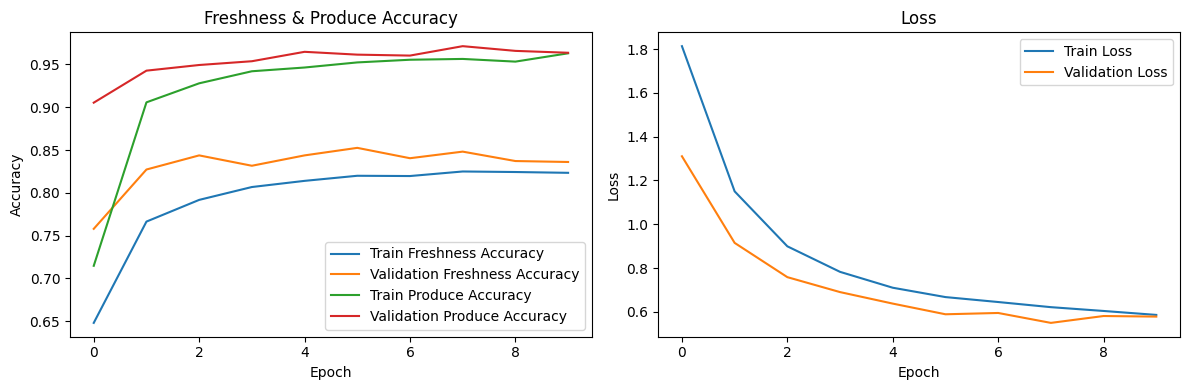

In [11]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_freshness_acc'], label='Train Freshness Accuracy')
plt.plot(history['val_freshness_acc'], label='Validation Freshness Accuracy')
plt.plot(history['train_produce_acc'], label='Train Produce Accuracy')
plt.plot(history['val_produce_acc'], label='Validation Produce Accuracy')
plt.title('Freshness & Produce Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Result: Fresh Apple
Freshness Confidence: 53.35%
Produce Confidence: 98.72%
Freshness Probabilities: fresh: 53.35%, slightly rotten: 16.90%, rotten: 29.74%
Produce Probabilities: apple: 98.72%, banana: 0.36%, potato: 0.87%, carrot: 0.06%


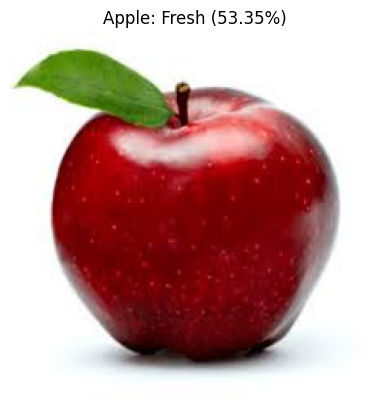

In [12]:
def predict_image(image_path, model, transform, device):
    freshness_classes = ['fresh', 'slightly rotten', 'rotten']
    produce_classes = ['apple', 'banana', 'potato', 'carrot']

    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        freshness_output, produce_output = model(input_tensor)
        freshness_probs = torch.nn.functional.softmax(freshness_output, dim=1)[0]
        produce_probs = torch.nn.functional.softmax(produce_output, dim=1)[0]

        freshness_score, freshness_idx = torch.max(freshness_probs, 0)
        produce_score, produce_idx = torch.max(produce_probs, 0)

        freshness_result = freshness_classes[freshness_idx.item()]
        produce_result = produce_classes[produce_idx.item()]
        freshness_conf = freshness_score.item() * 100
        produce_conf = produce_score.item() * 100

        freshness_prob_dict = {freshness_classes[i]: freshness_probs[i].item() * 100 for i in range(len(freshness_classes))}
        produce_prob_dict = {produce_classes[i]: produce_probs[i].item() * 100 for i in range(len(produce_classes))}

    return {
        'freshness': freshness_result,
        'produce': produce_result,
        'freshness_confidence': freshness_conf,
        'produce_confidence': produce_conf,
        'freshness_probs': freshness_prob_dict,
        'produce_probs': produce_prob_dict
    }

image_path = r'E:\eatfresh\freshapple.jpg'
model_path = r'E:\eatfresh\food_multi_task_model.pth'

model = create_multi_task_model()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

result = predict_image(image_path, model, data_transforms['test'], device)

print(f"Result: {result['freshness'].capitalize()} {result['produce'].capitalize()}")
print(f"Freshness Confidence: {result['freshness_confidence']:.2f}%")
print(f"Produce Confidence: {result['produce_confidence']:.2f}%")
print("Freshness Probabilities:", ', '.join([f"{k}: {v:.2f}%" for k, v in result['freshness_probs'].items()]))
print("Produce Probabilities:", ', '.join([f"{k}: {v:.2f}%" for k, v in result['produce_probs'].items()]))

image = Image.open(image_path)
plt.imshow(image)
plt.title(f"{result['produce'].capitalize()}: {result['freshness'].capitalize()} ({result['freshness_confidence']:.2f}%)")
plt.axis('off')
plt.show()


FileUpload(value=(), accept='image/*', description='Upload')

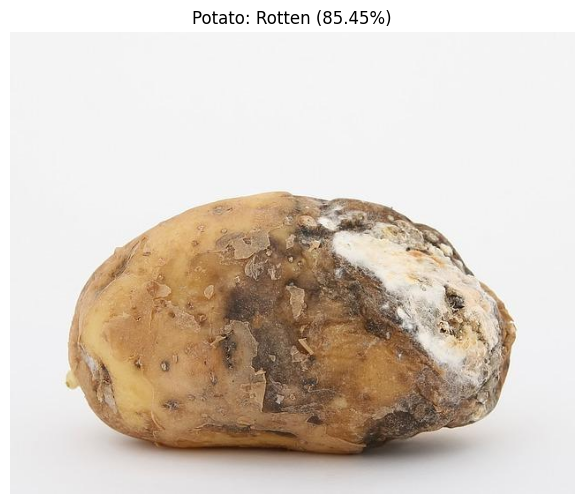

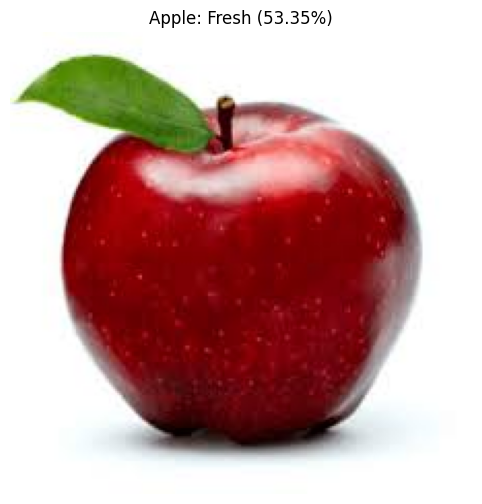

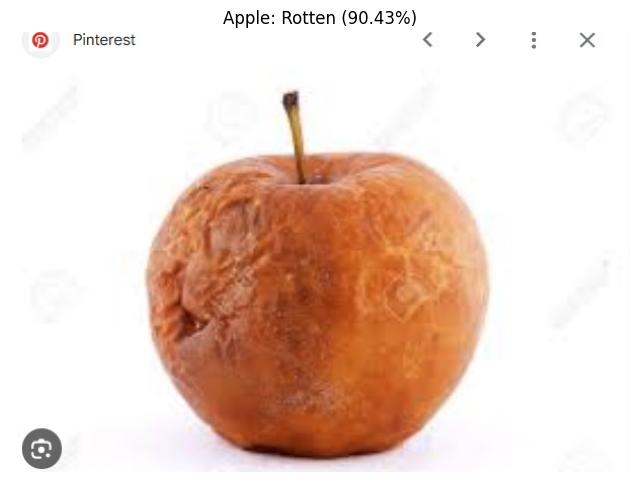

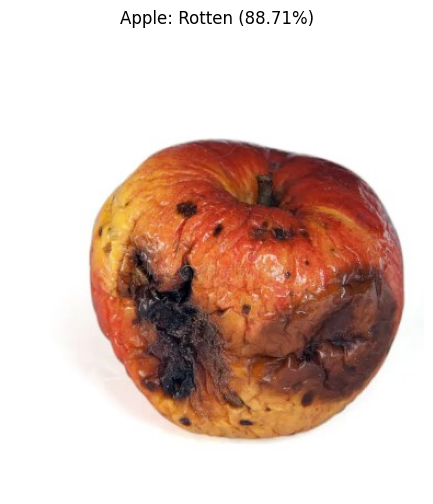

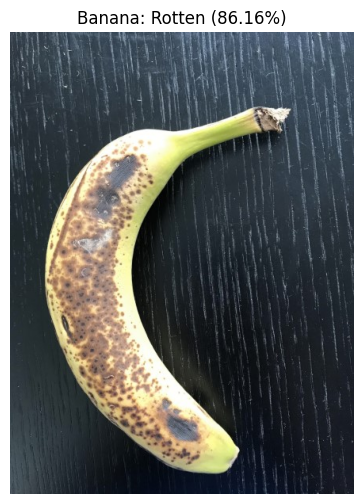

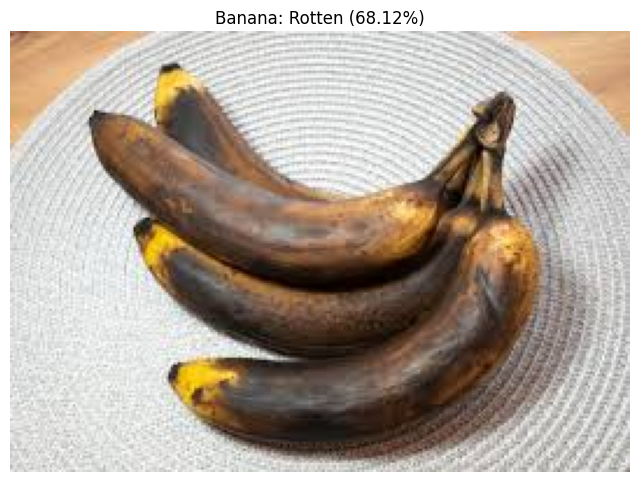

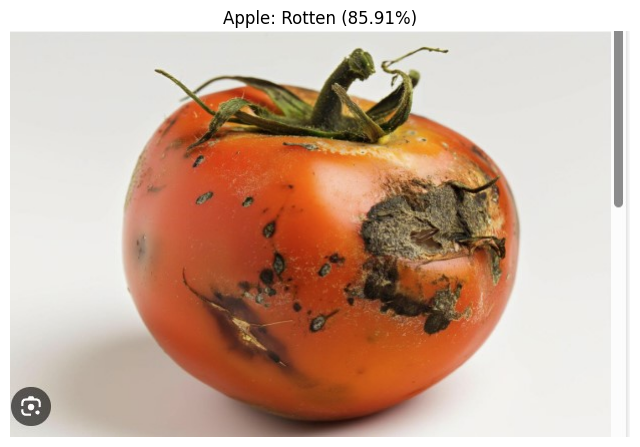

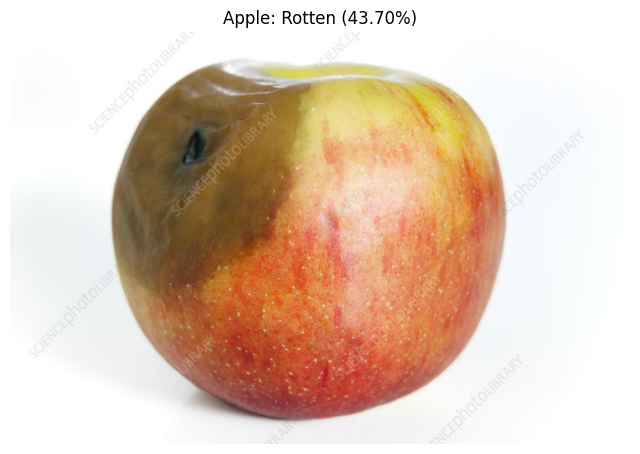

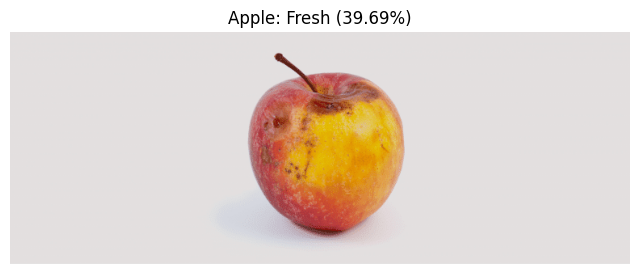

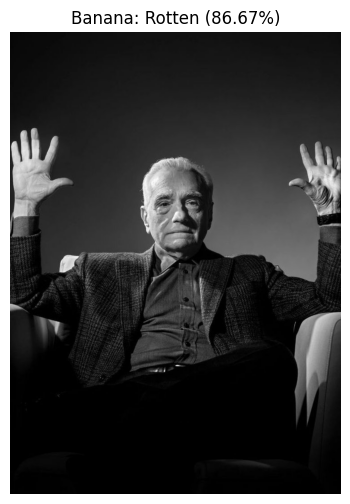

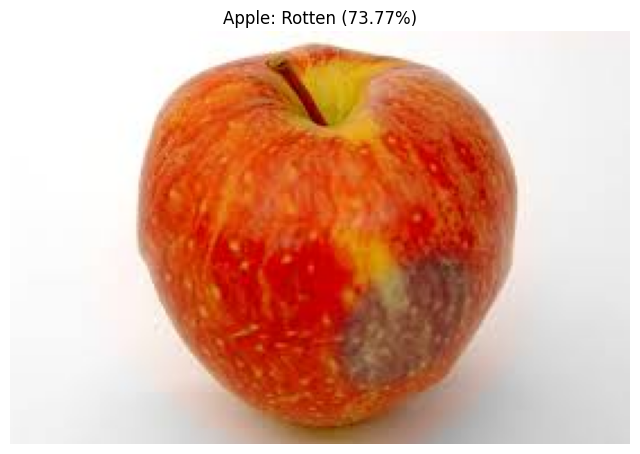

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def predict_image_from_bytes(image_bytes, model, transform, device):
    freshness_classes = ['fresh', 'slightly rotten', 'rotten']
    produce_classes = ['apple', 'banana', 'potato', 'carrot']

    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        freshness_output, produce_output = model(input_tensor)
        freshness_probs = torch.nn.functional.softmax(freshness_output, dim=1)[0]
        produce_probs = torch.nn.functional.softmax(produce_output, dim=1)[0]

        freshness_score, freshness_idx = torch.max(freshness_probs, 0)
        produce_score, produce_idx = torch.max(produce_probs, 0)

        freshness_result = freshness_classes[freshness_idx.item()]
        produce_result = produce_classes[produce_idx.item()]
        freshness_conf = freshness_score.item() * 100
        produce_conf = produce_score.item() * 100

        freshness_prob_dict = {freshness_classes[i]: freshness_probs[i].item() * 100 for i in range(len(freshness_classes))}
        produce_prob_dict = {produce_classes[i]: produce_probs[i].item() * 100 for i in range(len(produce_classes))}

    return image, {
        'freshness': freshness_result,
        'produce': produce_result,
        'freshness_confidence': freshness_conf,
        'produce_confidence': produce_conf,
        'freshness_probs': freshness_prob_dict,
        'produce_probs': produce_prob_dict
    }

model_path = r'E:\eatfresh\food_multi_task_model.pth'
model = create_multi_task_model()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

uploader = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    for fileinfo in uploader.value:
        filename = fileinfo['name']
        image_bytes = fileinfo['content']
        image, result = predict_image_from_bytes(image_bytes, model, data_transforms['test'], device)

        print(f"Result: {result['freshness'].capitalize()} {result['produce'].capitalize()}")
        print(f"Freshness Confidence: {result['freshness_confidence']:.2f}%")
        print(f"Produce Confidence: {result['produce_confidence']:.2f}%")
        print("Freshness Probabilities:", ', '.join([f"{k}: {v:.2f}%" for k, v in result['freshness_probs'].items()]))
        print("Produce Probabilities:", ', '.join([f"{k}: {v:.2f}%" for k, v in result['produce_probs'].items()]))

        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(f"{result['produce'].capitalize()}: {result['freshness'].capitalize()} ({result['freshness_confidence']:.2f}%)")
        plt.axis('off')
        plt.show()


uploader.observe(on_upload_change, names='value')

display(uploader)
